In [ ]:
import cv2
import numpy as np
from dehaze.Airlight import Airlight
from dehaze.BoundCon import BoundCon
from dehaze.CalTransmission import CalTransmission
from dehaze.removeHaze import removeHaze
import matplotlib.pyplot as plt

In [ ]:
img_path = '/mnt/c/Users/83555/AppData/Roaming/PotPlayerMini64/Capture/Push.png'
HazeImg = cv2.imread(img_path)
HazeImg_ = 255-HazeImg

In [ ]:
windowSze = 15
AirlightMethod = 'fast'
A = Airlight(HazeImg_, AirlightMethod, windowSze)

# Calculate Boundary Constraints
windowSze = 3
C0 = 20         # Default value = 20 (as recommended in the paper)
C1 = 300        # Default value = 300 (as recommended in the paper)
Transmission = BoundCon(HazeImg_, A, C0, C1, windowSze)                  #   Computing the Transmission using equation (7) in the paper

# Refine estimate of transmission
regularize_lambda = 1       # Default value = 1 (as recommended in the paper) --> Regularization parameter, the more this  value, the closer to the original patch wise transmission
sigma = 0.5
Transmission = CalTransmission(HazeImg_, Transmission, regularize_lambda, sigma)     # Using contextual information

# Perform DeHazing
HazeCorrectedImg = removeHaze(HazeImg_, Transmission, A, 0.85)
HazeCorrectedImg = 255-HazeCorrectedImg

In [ ]:
plt.imshow(HazeImg[...,::-1])

In [ ]:
plt.imshow(HazeCorrectedImg[...,::-1])

# kaimin he

In [ ]:
def get_dark_channel(image):
    patchSize = 15
    padSize = 7
    height, width, channel = image.shape
    jDark = np.zeros((height, width))

    for j in range(height):
        for i in range(width):
            tmp = []
            for c in range(channel):
                tmp.append(image[j, i, c])
            jDark[j, i] = min(tmp)

    img = np.pad(jDark, ((padSize, padSize), (padSize, padSize)), mode='constant', constant_values=(255))
    for r in range(height):
        for c in range(width):
            patch = img[r: (r + patchSize - 1), c: (c + patchSize - 1)]
            jDark[r, c] = patch.min()

    return jDark

def estimate_atmospheric_light(image, jDark):
    height, width, channel = image.shape
    # 0.1%
    numpx = max(width * height / 1000, 1)
    jDarkVec = np.reshape(jDark, (width * height))
    imgVec = np.reshape(image, (width * height, channel))
    indices = np.argsort(jDarkVec)   
    brightest_indices = indices[int(width * height - numpx):]
    atmSum = np.zeros(channel)
    for i in range(int(numpx)):
        atmSum = atmSum + imgVec[brightest_indices[i]]
    A = atmSum / numpx
    print(A)
    return A

def estimate_transmission(image, A):
    omega = 0.96
    height, width, channel = image.shape
    img = np.zeros((height, width, channel))
    for c in range(channel):
        img[:, :, c] = image[:, :, c] / float(A[c])
    transmission = 1 - omega * get_dark_channel(img)
    return transmission

def dehaze(image, A, transmission):
    t0 = 0.1
    height, width, channel = image.shape
    J = np.zeros((height, width, channel))
    for c in range(channel):
        J[:, :, c] = A[c] + (image[:, :, c] - A[c])/np.maximum(transmission, t0)
    return J

In [ ]:
dark_image = get_dark_channel(HazeImg_)
A = estimate_atmospheric_light(HazeImg_, dark_image)
transmission = estimate_transmission(HazeImg_, A)
dehaze_image = dehaze(HazeImg_, A, transmission)
dehaze_image = dehaze_image / np.amax(dehaze_image)

In [ ]:
plt.imshow(1-dehaze_image[...,::-1])

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def pool2d(A, kernel_size, stride=1, pool_mode='max'):

    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)
    
    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])
    
    A_w = as_strided(A, shape_w, strides_w)

    if pool_mode == 'max':
        return A_w.max(axis=(2, 3))
    elif pool_mode == 'avg':
        return A_w.mean(axis=(2, 3))
    elif pool_mode == 'min':
        return A_w.min(axis=(2, 3))

class DarkEnhance(object):
    def __init__(self):
        pass
    
    def get_dark_channel(self, image):
        patchSize = 15
        padSize = int(7)
        height, width, channel = image.shape
        jDark = np.min(image,axis=2)

        img = np.pad(jDark, ((padSize, padSize), (padSize, padSize)), mode='constant', constant_values=(255))
        print('img',img.shape)

        jDark = pool2d(img, patchSize, pool_mode='min')
        print('jDark',jDark.shape)

        return jDark

    def estimate_atmospheric_light(self, image, jDark):
        height, width, channel = image.shape
        # 0.1%
        numpx = max(width * height / 1000, 1)
        jDarkVec = np.reshape(jDark, (width * height))
        print(jDarkVec)
        
        print('jDarkVec',jDarkVec.shape)
        imgVec = np.reshape(image, (width * height, channel))
        print('imgVec',imgVec.shape)
        indices = np.argsort(jDarkVec)
        print(indices)
        print('indices',indices.shape)
        brightest_indices = indices[int(width * height - numpx):]
        print('brightest_indices',brightest_indices.shape)
        idx = imgVec[brightest_indices[1]]
        print('idx',idx.shape)
        # atmSum = np.zeros(channel)
        # for i in range(int(numpx)):
        #     atmSum = atmSum + imgVec[brightest_indices[i]]
        atmSum = np.sum(imgVec[brightest_indices[:int(numpx)]],axis=0)
        A = atmSum / numpx
        print(A.shape)
        return A

    def estimate_transmission(self, image, A):
        omega = 0.96
        height, width, channel = image.shape
        img = np.multiply(image,1/A.astype('float'))
        transmission = 1 - omega * self.get_dark_channel(img)
        return transmission

    def dehaze(self, image, A, transmission):
        t0 = 0.1
        height, width, channel = image.shape
        J = np.zeros((height, width, channel))
        print(np.maximum(transmission, t0).shape)
        J= A + (image - A)/np.maximum(transmission, t0).reshape(height,width,1)
        return J

    def enhance(self, HazeImg):
      HazeImg_ = 255-HazeImg
      dark_image = self.get_dark_channel(HazeImg_)
      A = self.estimate_atmospheric_light(HazeImg_, dark_image)
      transmission = self.estimate_transmission(HazeImg_, A)
      dehaze_image = self.dehaze(HazeImg_, A, transmission)
      dehaze_image = 1 - dehaze_image / np.amax(dehaze_image)
      print('np.amax',np.amax(dehaze_image))
      return (dehaze_image*255).astype('uint8')

    def __call__(self, img):
        return self.enhance(img)

In [ ]:
enhancer_N = DarkEnhance()
dehaze_image = enhancer_N(HazeImg)

In [ ]:
plt.imshow(dehaze_image[...,::-1])

In [71]:
import torch
import torch.nn.functional as F
class TorchDarkEnhance(torch.nn.Module):
    def __init__(self, patch_size: int = 7, pad_size: int = 3, omega: float = 0.98, t0: float = 0.15) -> None:
        super().__init__()
        self.omega = omega
        self.t0 = torch.tensor([t0])
        self.pad = torch.nn.ConstantPad2d(
            (pad_size, pad_size, pad_size, pad_size), 255.0)
        self.max_filter = torch.nn.MaxPool2d(kernel_size=patch_size, stride=1)

    def get_dark_channel(self, image: torch.Tensor):
        jDark = image.min(-1).values
        img = self.pad(jDark)
        jDark = -self.max_filter(-img)
        return jDark

    def estimate_atmospheric_light(self, image: torch.Tensor, jDark: torch.Tensor):
        height, width = jDark.shape[1], jDark.shape[2]
        numpx = max(width * height // 1000, 1)
        jDarkVec = jDark.flatten(1, 2)
        imgVec = image.flatten(1, 2)
        #_, indices = torch.sort(jDarkVec, stable=True)
        #A = imgVec[torch.arange(imgVec.shape[0]).unsqueeze(-1),indices[:,int(width * height - numpx):-1]].mean(1)
        # A = torch.gather(imgVec, 1, indices[:, int(
        #     width * height - numpx):-1, None]).mean(1)
        _, indices = torch.topk(jDarkVec, k=int(numpx), dim=1, largest=True)
        A = torch.gather(imgVec, 1, indices[:, :, None]).mean(1)
        return A[:, None, None, :], indices

    def estimate_transmission(self, image: torch.Tensor, A: torch.Tensor):
        transmission = 1 - self.omega * self.get_dark_channel(image/A)
        return transmission

    def dehaze(self, image: torch.Tensor, A: torch.Tensor, transmission: torch.Tensor):
        J = A + (image - A)/torch.maximum(transmission, self.t0.to(transmission.device)).unsqueeze(-1)
        return J
        

    def forward(self, HazeImg: torch.Tensor):
        HazeImg_ = HazeImg
        dark_image = self.get_dark_channel(HazeImg_)
        dark_image_ = dark_image.clone()
        A,indices = self.estimate_atmospheric_light(HazeImg_, dark_image)
        transmission = self.estimate_transmission(HazeImg_, A)
        dehaze_image = self.dehaze(HazeImg_, A, transmission)
        dehaze_image = dehaze_image / \
            torch.amax(dehaze_image, (1, 2, 3), True)
        return dehaze_image*255, dark_image_, indices

torch.Size([1, 3, 240, 320])


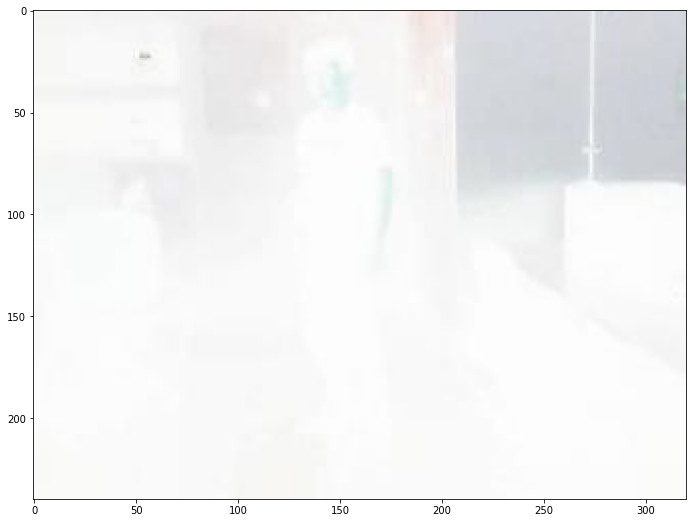

In [72]:
from torchvision.io import read_image
import matplotlib.pyplot as plt
img = read_image('/home/neoncloud/low_light/test/000071_inv.jpg').unsqueeze(0).float()
print(img.shape)
plt.figure(figsize=(12,9))
plt.imshow((img).squeeze().permute(1,2,0).to(torch.uint8).numpy())

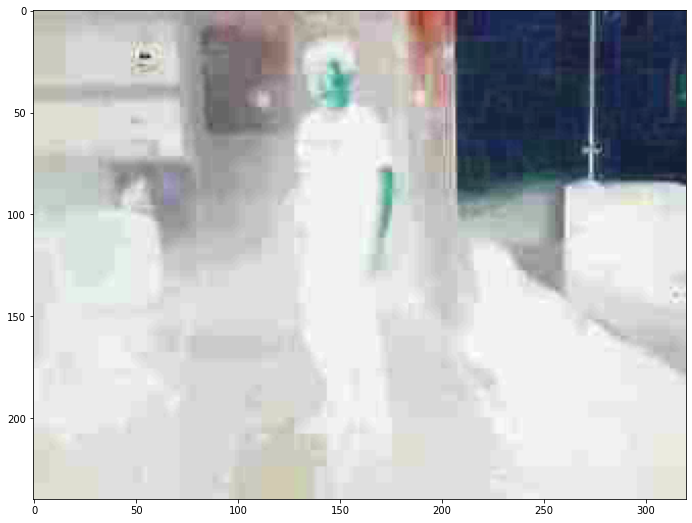

In [73]:
enhancer = TorchDarkEnhance()
dehaze_image, dark_image, indices = enhancer(img.transpose(1,3))
plt.figure(figsize=(12,9))
plt.imshow((dehaze_image).squeeze().permute(1,0,2).to(torch.uint8).numpy())

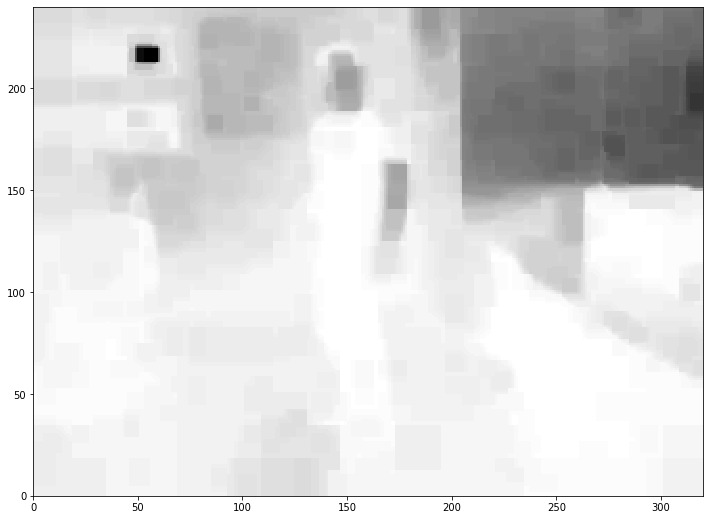

In [74]:
plt.figure(figsize=(12,9))
plt.pcolor((dark_image).squeeze().permute(1,0).flip(0).to(torch.uint8).numpy(), cmap='gray')

torch.Size([76])


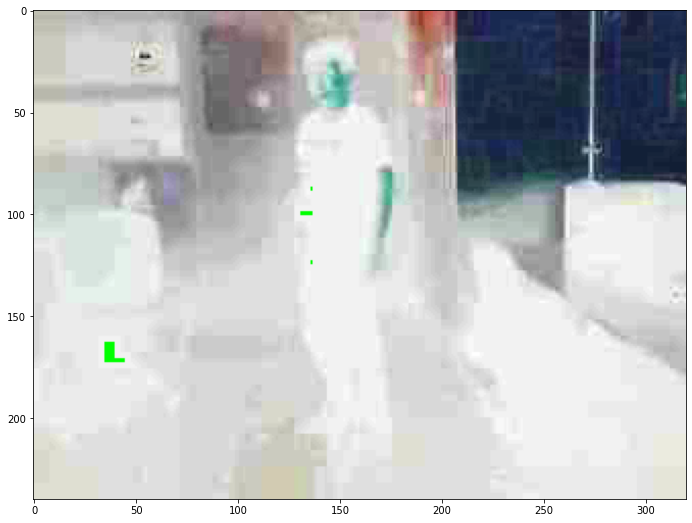

In [77]:
print(indices.shape)
A = dehaze_image.clone().squeeze().flatten(0,1)
indices.squeeze_()
A[indices,:] = torch.tensor([0.0,255.0,0])
A = A.reshape(320,240,-1)
plt.figure(figsize=(12,9))
plt.imshow(A.permute(1,0,2).to(torch.uint8).numpy())

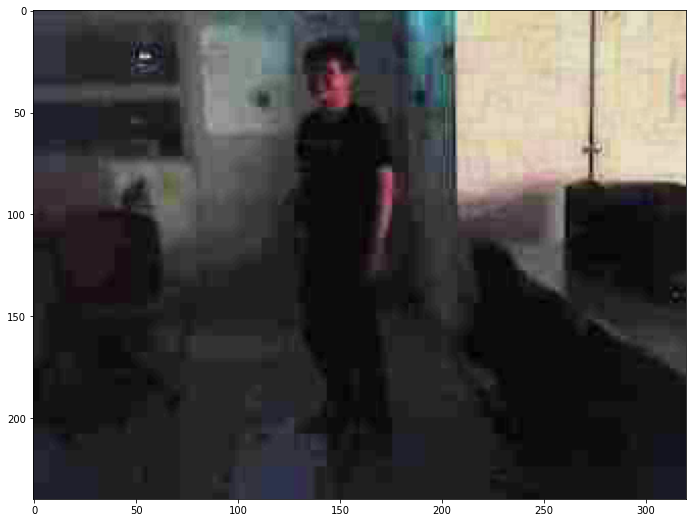

In [79]:
plt.figure(figsize=(12,9))
plt.imshow((255.0-dehaze_image).squeeze().permute(1,0,2).to(torch.uint8).numpy())

In [ ]:
from torchvision.io import read_video
frames, _, info  = read_video('/home/neoncloud/Drink_12_1.mp4')
print('frames',frames.shape)
print(info)

enhancer_T = TorchDarkEnhance()
enhanced_img = enhancer_T.forward(frames)

In [ ]:
plt.imshow(enhanced_img[0,...].numpy())

In [ ]:
enhancer_N = DarkEnhance()
dehaze_image = enhancer_N(frames[0,...].numpy())
plt.imshow(dehaze_image)